In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contextily as ctx
import pyproj
from shapely.geometry import Point, LineString
from zipfile import ZipFile, Path
import datetime
from matplotlib.colors import TwoSlopeNorm

### Step 1: Load GTFS Data and Define Columns

Load the relevant GTFS data Zipfile.(To enhance load performance and ensure that joins between data frames function correctly, it is essential to explicitly define the data type for each column).

In [20]:
with ZipFile("C:\\Users\\farsh\\Desktop\\gtfs\\TTC Routes and Schedules Data.zip") as myzip:
    stops_df = pd.read_csv(myzip.open("stops.txt"), dtype={ 
    'stop_id': 'str', 
    'stop_code': 'str',
    'stop_name': 'str',
    'stop_desc' : 'str',                                              
    'stop_lat': 'float',
    'stop_lon': 'float',
    'location_type': 'Int64',
    'parent_station': 'str',
    'wheelchair_boarding': 'str', 
    'platform_code': 'str',
    'zone_id': 'str',
    'level_id' : 'str'
    })
    
    
    stop_times_df = pd.read_csv(myzip.open("stop_times.txt"), dtype={
        'trip_id': 'str',
        'arrival_time': 'str',
        'stop_id': 'str', 
        'departure_time': 'str', 
        'stop_id': 'str',
        'stop_sequence': 'Int64',
        'stop_headsign': 'str',
        'pickup_type': 'Int64',
        'drop_off_type': 'Int64',
    })
    
    
    
    routes_df = pd.read_csv(myzip.open("routes.txt"), dtype={
        'route_id': 'str',  
        'agency_id': 'str',  
        'route_short_name': 'str',  
        'route_long_name': 'str', 
        'route_desc': 'str', 
        'route_type': 'Int64',
        'route_color': 'str',  
        'route_text_color': 'str', 
        'rout_desc': 'str'
    })
    
    trips_df = pd.read_csv(myzip.open("trips.txt"), dtype={
        'route_id': 'str', 
        'service_id': 'str',  
        'trip_id': 'str',
        'shape_id': 'str', 
        'trip_headsign': 'str',
        'trip_short_name': 'str',
        'direction_id': 'Int64',  
        'block_id': 'str',
        'shape_id': 'str',
        'wheelchair_accessible': 'str',  
        'bikes_allowed': 'str'
    })
    
    shapes_df = pd.read_csv(myzip.open("shapes.txt"), dtype={
        'shape_id': 'str', 
        'shape_pt_lat': 'float', 
        'shape_pt_lon': 'float',  
        'shape_pt_sequence': 'Int64'
    })
    
    calendar_df = pd.read_csv(myzip.open("calendar.txt"), dtype={
        'service_id': 'str',  
        'monday': 'bool',  
        'tuesday': 'bool',  
        'wednesday': 'bool',  
        'thursday': 'bool',  
        'friday': 'bool', 
        'saturday': 'bool',  
        'sunday': 'bool',  
        'start_date': 'str', 
        'end_date': 'str',
    })
    
    calendar_dates_df = pd.read_csv(myzip.open("calendar_dates.txt"), dtype={
        'service_id': 'str',  
        'date': 'str',
        'exception_type': 'Int64',
    })
    
    agency_df = pd.read_csv(myzip.open("agency.txt"), dtype={
        'agency_id': 'str', 
        'agency_name': 'str', 
        'agency_url': 'str',  
        'agency_timezone': 'str',
        'agency_lang': 'str', 
        'agency_phone': 'str',
    })

### Step2: Identify Active Services for a Specific Date
This steo identifies active services for specific date (2024-05-12) by filtering regular schedules (calendar_df) based on the day of the week and date range. It includes exceptions for services added (exception_type == 1) or removed (exception_type == 2) on that date (calendar_dates_df). The final list merges regular and added services, excluding removed ones.

In [22]:
running_date = "2024-05-12"

date = datetime.datetime.strptime(running_date, "%Y-%m-%d")
date_string = date.strftime("%Y%m%d")
day_of_week_name = date.strftime('%A').lower()

services_for_day_1 = calendar_df[(calendar_df[day_of_week_name]) & (date_string >= calendar_df.start_date) & (date_string <= calendar_df.end_date)].service_id.to_numpy()

services_added_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 1)].service_id.to_numpy()
services_removed_for_day = calendar_dates_df[(calendar_dates_df.date == date_string) & (calendar_dates_df.exception_type == 2)].service_id.to_numpy()
services_for_day_2 = np.concatenate([services_for_day_1, services_added_for_day])
services_for_day = np.setdiff1d(services_for_day_2, services_removed_for_day)


### Step3: Extract Route Segments with Coordinates and Sequence
This step extracts route segments from shapes_df by pairing each point's coordinates and sequence number with the preceding point using np.roll. It combines start and end points into a dataframe, adds the shape_id, filters out invalid segments (where end_seq == 1), and refines columns for clarity. The resulting segments_df contains each segment's start and end coordinates, sequence number, and associated shape_id for analysis

In [23]:
coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
coords_roll_1 = np.roll(coords, 1, axis=0)

segments = pd.DataFrame(np.concatenate([coords_roll_1, coords], axis=1), columns=["start_lat", "start_lng", "start_seq", 
                                                                       "end_lat", "end_lng", "end_seq"])
segments_df = shapes_df[["shape_id"]].join(segments)
segments_df = segments_df[segments_df.end_seq != 1]
segments_df = segments_df.drop(columns=['end_seq']).rename(columns={ "start_seq": "seq" })
segments_df

,shape_id,start_lat,start_lng,seq,end_lat,end_lng
1,1015056,43.789038,-79.330471,1,43.789244,-79.329574
2,1015056,43.789244,-79.329574,2,43.787992,-79.328993
3,1015056,43.787992,-79.328993,3,43.785857,-79.327985
4,1015056,43.785857,-79.327985,4,43.785722,-79.327921
5,1015056,43.785722,-79.327921,5,43.785436,-79.329186
...,...,...,...,...,...,...
403209,1018208,43.763013,-79.404128,49,43.762831,-79.404955
403210,1018208,43.762831,-79.404955,50,43.762279,-79.407368
403211,1018208,43.762279,-79.407368,51,43.762048,-79.408461
403212,1018208,43.762048,-79.408461,52,43.76175,-79.409808


### Step 4: Filter Trips for the Buses only on a Specific Day
This step filters trips active on a specific day to include only those belonging to bus routes (route_type == 3) and groups them by shape_id with the count of trips per shape.

In [24]:
trips_for_day = trips_df[trips_df.service_id.isin(services_for_day)]
toronto_bus_route_ids = routes_df[(routes_df['route_type'] == 3) ].route_id.unique()
day_trip_buses = trips_for_day[trips_for_day.route_id.isin(toronto_bus_route_ids)].groupby(by='shape_id').size().to_frame('trips_for_day')

In [25]:
day_trip_buses

,trips_for_day
shape_id,
1015061,115
1015062,116
1015064,1
1015065,27
1015066,1
...,...
1017220,35
1017234,79
1017236,77


### Step 6: Calculate the Number of Buses Running Along Each Route Segment
This step calculates the number of buses running daily along each route segment by first merging segments_df, which contains route segments defined by their start and end coordinates, with day_trip_buses, which holds the count of trips for each shape ID active on the given day.

In [26]:
shape_segments_day_trips = pd.merge(segments_df, day_trip_buses, left_on="shape_id", right_index=True)

# how many trip occurs in each segment per day
shape_segments_day_trips = pd.merge(segments_df, day_trip_buses, left_on="shape_id", right_index=True)

In [27]:
segment_day_trips = shape_segments_day_trips.groupby(by=[
    "start_lat", "start_lng", "end_lat", "end_lng"]).sum("day_trips").reset_index()

In [28]:
segment_day_trips

,start_lat,start_lng,end_lat,end_lng,trips_for_day
0,43.591495,-79.544511,43.591511,-79.544427,103
1,43.591508,-79.544592,43.591495,-79.544511,103
2,43.591511,-79.544427,43.591567,-79.544350,103
3,43.591543,-79.544658,43.591508,-79.544592,103
4,43.591567,-79.544350,43.591634,-79.544309,103
...,...,...,...,...,...
69873,43.908093,-79.274836,43.908530,-79.272869,16
69874,43.908530,-79.272869,43.908764,-79.271952,16
69875,43.908764,-79.271952,43.909256,-79.269906,16
69876,43.909256,-79.269906,43.909681,-79.268080,33


### Step 7: Convert Route Segments to LineString Geometry and Create a GeoDataFrame
This step transforms route segment data into geospatial format by creating a LineString geometry for each segment, which represents the connection between the segment's start and end coordinates. A function, get_line_string, is applied to each row of the segment_day_trips dataframe to generate Point objects for the start and end coordinates and form a LineString that is added to a new "geometry" column.

In [29]:
from shapely.geometry import Point, LineString

def get_line_string(row):
    start = Point(row.start_lng, row.start_lat)
    end = Point(row.end_lng, row.end_lat)
    line = LineString([start, end])
    row["geometry"] = line
    return row

In [30]:
segment_day_trips_gpd = gpd.GeoDataFrame(segment_day_trips.apply(get_line_string, axis=1)).set_crs(epsg=4326)

In [31]:
segment_day_trips_gpd

,start_lat,start_lng,end_lat,end_lng,trips_for_day,geometry
0,43.591495,-79.544511,43.591511,-79.544427,103.0,"LINESTRING (-79.54451 43.59150, -79.54443 43.5..."
1,43.591508,-79.544592,43.591495,-79.544511,103.0,"LINESTRING (-79.54459 43.59151, -79.54451 43.5..."
2,43.591511,-79.544427,43.591567,-79.544350,103.0,"LINESTRING (-79.54443 43.59151, -79.54435 43.5..."
3,43.591543,-79.544658,43.591508,-79.544592,103.0,"LINESTRING (-79.54466 43.59154, -79.54459 43.5..."
4,43.591567,-79.544350,43.591634,-79.544309,103.0,"LINESTRING (-79.54435 43.59157, -79.54431 43.5..."
...,...,...,...,...,...,...
69873,43.908093,-79.274836,43.908530,-79.272869,16.0,"LINESTRING (-79.27484 43.90809, -79.27287 43.9..."
69874,43.908530,-79.272869,43.908764,-79.271952,16.0,"LINESTRING (-79.27287 43.90853, -79.27195 43.9..."
69875,43.908764,-79.271952,43.909256,-79.269906,16.0,"LINESTRING (-79.27195 43.90876, -79.26991 43.9..."
69876,43.909256,-79.269906,43.909681,-79.268080,33.0,"LINESTRING (-79.26991 43.90926, -79.26808 43.9..."


### Step 8: Visualize Route Segments with Trip Counts Using a Color Gradient:

This step visualizes the number of bus trips per day on Toronto’s route segments using a color-coded map.A bounding box filters the GeoDataFrame to include only segments within Toronto's geographic area. The filtered segments are plotted with the viridis colormap to represent trip intensity, and a legend is added for clarity. The plot is displayed on a black background for enhanced contrast, titled with the date and context, and saved as an image for further use. This map provides a clear and engaging way to analyze bus activity across the network.

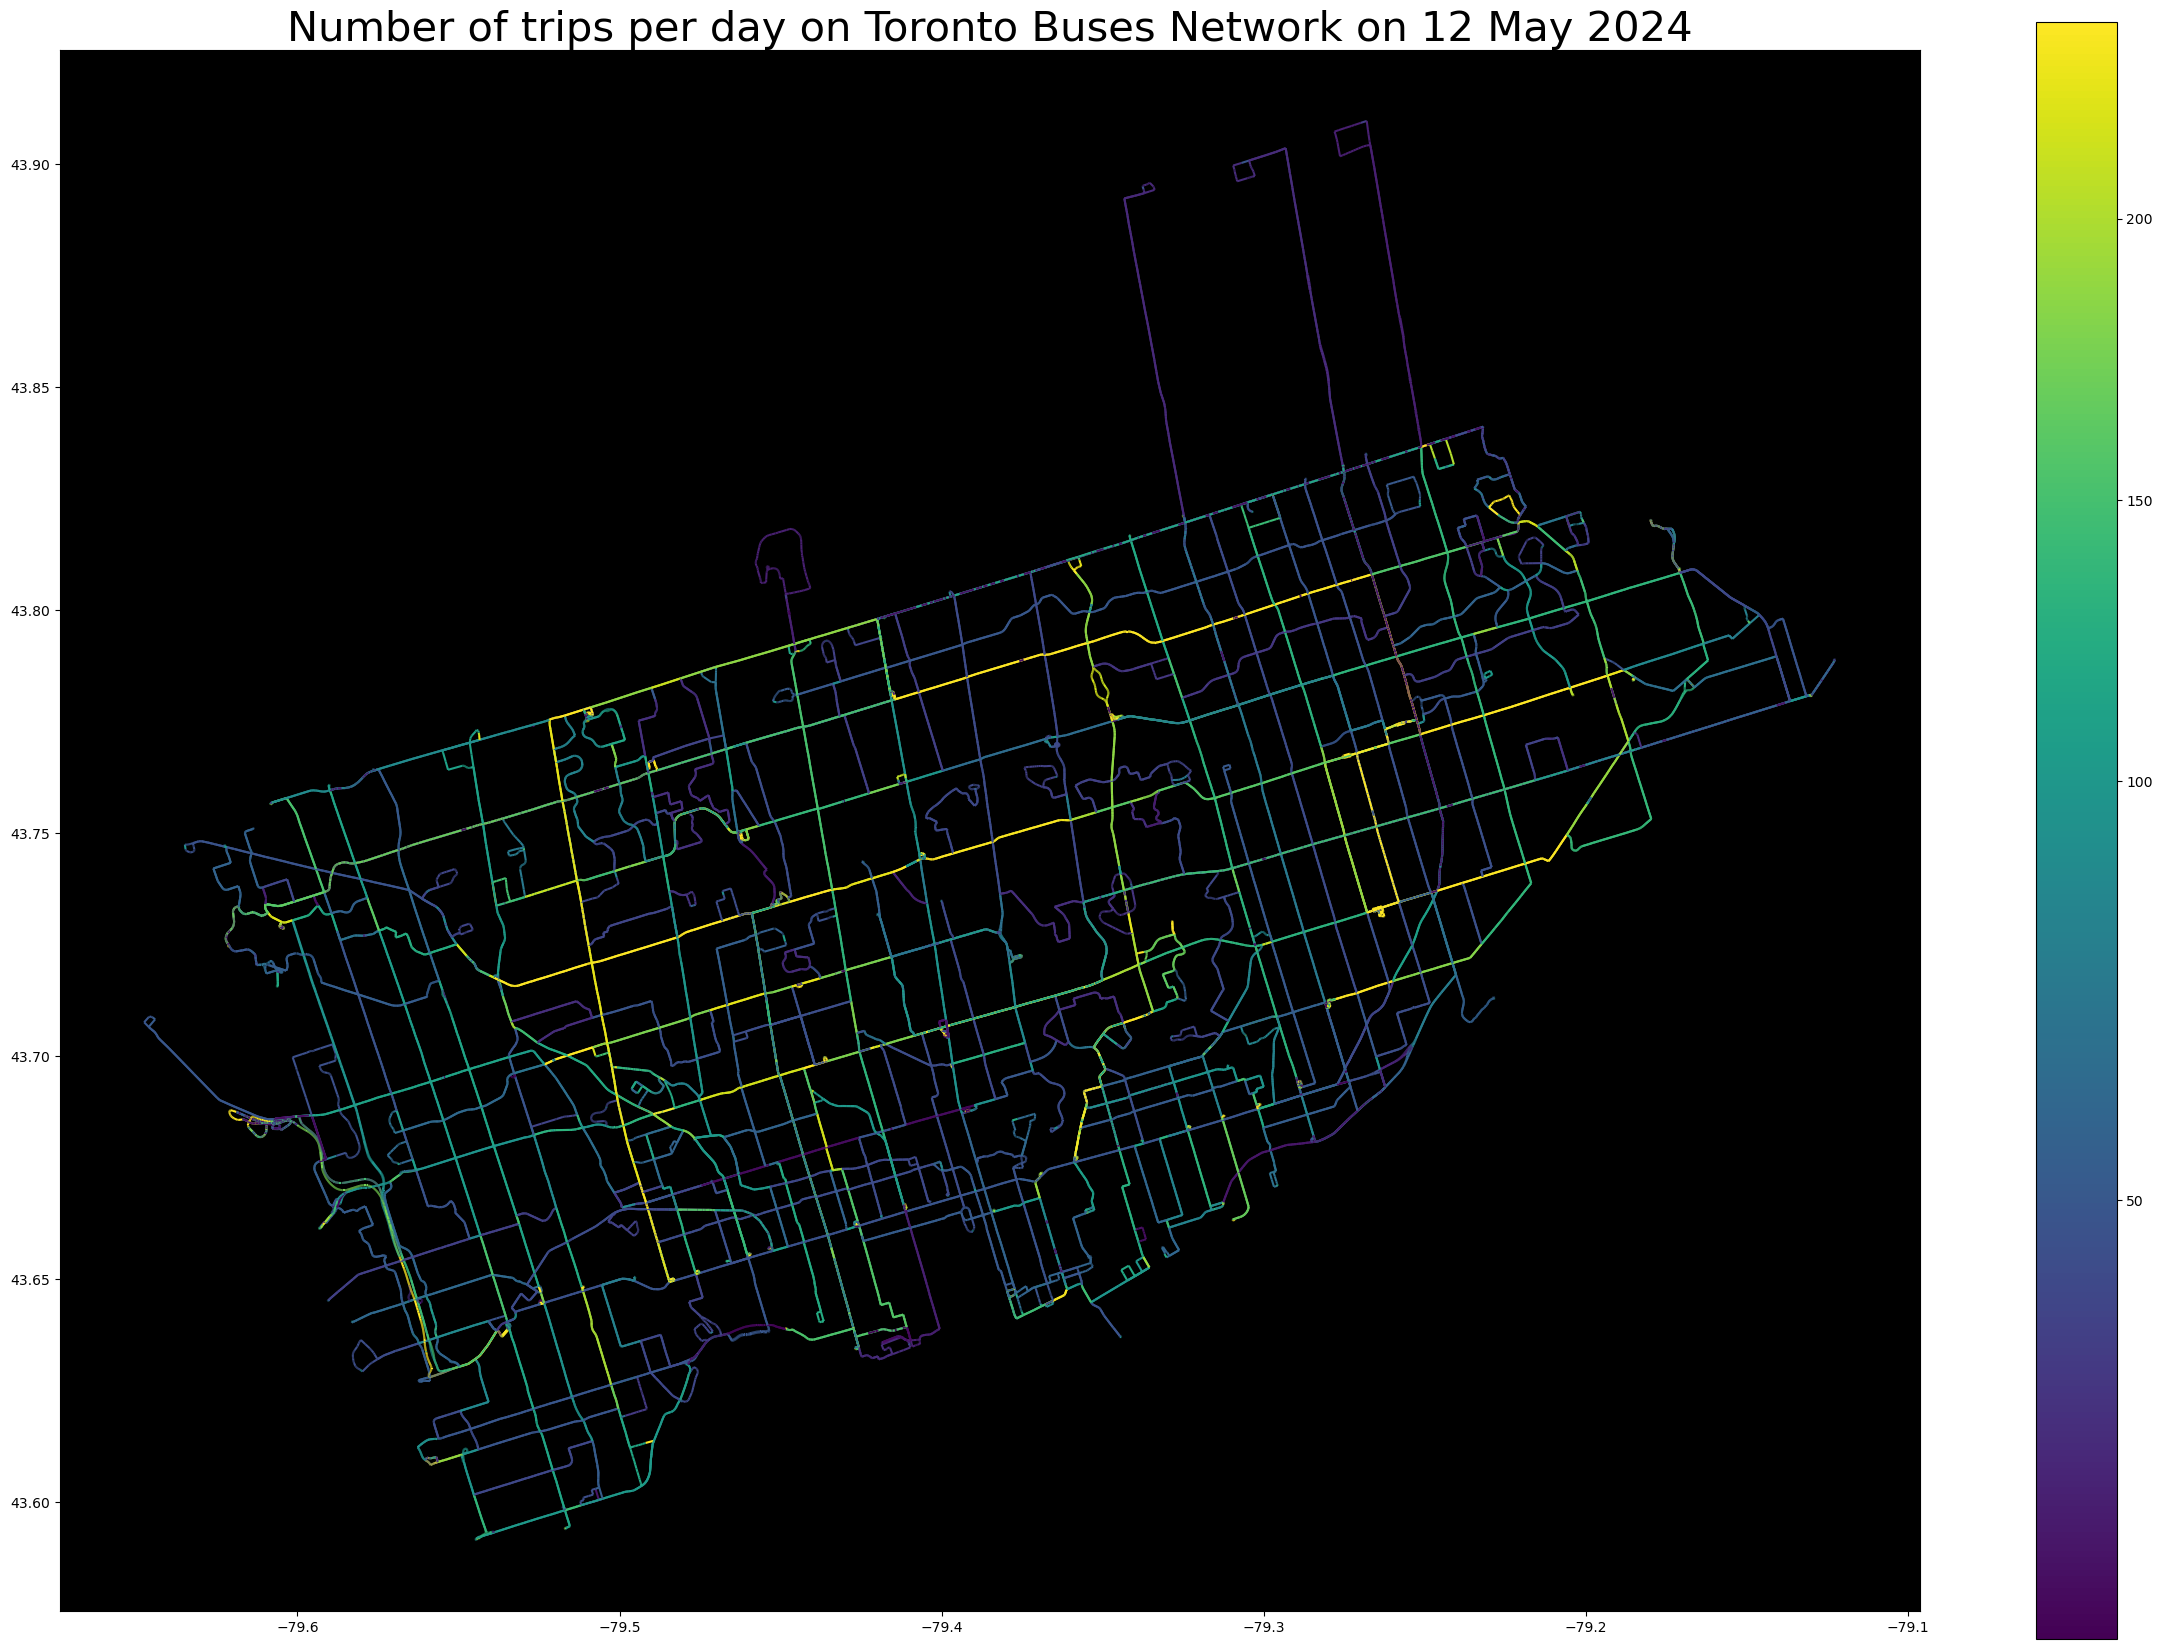

In [33]:
vmin = segment_day_trips_gpd["trips_for_day"].min()
vmax = segment_day_trips_gpd["trips_for_day"].quantile(.95)
vcenter = segment_day_trips_gpd["trips_for_day"].mean()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")

def toronto_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]
toronto_bb = {
    "north": 44.05,
    "south": 43.35,
    "west": -79.65,
    "east": -79.12
}

toronto_segment_day_trips_gpd = toronto_bounding_box(segment_day_trips_gpd, toronto_bb)

toronto_segment_day_trips_gpd.plot(ax=ax, cmap="viridis", column='trips_for_day', legend=True, norm=norm)

ax.set_title(f"Number of trips per day on Toronto Buses Network on {date:%d %B %Y}", fontsize=30)

plt.savefig("Toronto Buses Network.jpeg")
